# Imports

In [5]:
import re
import numpy as np
from countrycode import countrycode
import phonenumbers
from phonenumbers.phonenumberutil import region_code_for_number
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm_notebook
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from pathlib import Path
from nltk.corpus import stopwords
import nltk
import spacy
import string
from pprint import pprint

# Configuration

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
pd.set_option('display.max_colwidth', None)

In [3]:
argentina_area_codes = pd.read_csv("./argentina-area-codes.csv")

In [ ]:
argentina = geopandas.read_file("./localidades.shp")
argentina.plot()

In [5]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load toxicity model

In [6]:
from detoxify import Detoxify
model = Detoxify('multilingual')

def get_toxicity(message):
  return model.predict(message)["toxicity"]

/home/juan/WhatsappAnalyzer/mundialdelectura/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Read from file

## Read from pickel file if exists

In [6]:
path = Path("./Chat_as_DF.pkl")
if path.is_file():
    after_process = pd.read_pickle(path)
    print(u'\u2713')

✓


In [9]:
after_process

,User,Message_Raw,Message_Clean,Message_Only_Text,Toxicity,Date,Hour,Day_of_Week
0,54 9 11 3763-1285,"10/3/2024, 12:44 - +54 9 11 3763-1285: Muchas ...",Muchas Gracias !!! Ya compre entradas.,muchas gracias !!! ya compre entradas.,0.000519,2024-03-10 12:44:00,12,6
0,54 9 11 6544-3716,"10/3/2024, 14:07 - +54 9 11 6544-3716: https:/...",https://eternacadencia.com.ar/nota/borges-pres...,https://eternacadencia.com.ar/nota/borges-pres...,0.000374,2024-03-10 14:07:00,14,6
0,54 9 11 6544-3716,"10/3/2024, 14:09 - +54 9 11 6544-3716: Borges ...","Borges , el lector conmovido","borges , el lector conmovido",0.002860,2024-03-10 14:09:00,14,6
0,593 98 758 1373,"10/3/2024, 17:03 - +593 98 758 1373: https://a...",https://almomento.net/cecilia-ingenieros-borge...,https://almomento.net/cecilia-ingenieros-borge...,0.000731,2024-03-10 17:03:00,17,6
0,593 98 758 1373,"10/3/2024, 17:04 - +593 98 758 1373: Muy inter...","Muy interesante información sobre ""Emma Zunz"" ...","muy interesante información sobre ""emma zunz"" ...",0.000300,2024-03-10 17:04:00,17,6
...,...,...,...,...,...,...,...,...
0,54 9 2314 41-1016,"10/5/2024, 16:28 - +54 9 2314 41-1016: Me enca...",Me encantò!!! Gracias sss 💚,me encantò!!! gracias sss 💚,0.001636,2024-05-10 16:28:00,16,4
0,54 9 2314 41-1016,"10/5/2024, 16:30 - +54 9 2314 41-1016: Es mara...",Es maravilloso este grupo! Y qué placer la lec...,es maravilloso este grupo! y qué placer la lec...,0.000527,2024-05-10 16:30:00,16,4
0,54 9 11 4084-4598,"10/5/2024, 16:57 - +54 9 11 4084-4598: https:/...",https://youtu.be/DbXLrkMFm8Q?si=HvWiLFqKP8fb_4Yx,https://youtu.be/dbxlrkmfm8q?si=hvwilfqkp8fb_4yx,0.000500,2024-05-10 16:57:00,16,4
0,54 9 11 4084-4598,"10/5/2024, 16:58 - +54 9 11 4084-4598: No sé s...","No sé si alguien lo compartió ya, pero es un v...","no sé si alguien lo compartió ya, pero es un v...",0.000463,2024-05-10 16:58:00,16,4


## Read from txt file

In [4]:
splitted_chat = []
with open("./chats/chats.txt", "r") as chat:
    all_chat = chat.read().replace("\n", " ")
    splitted_chat = re.findall("\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+[()\d\w\s-]+: [\s\S]*?(?=\d{1,2}\/\d{1,2}\/\d{4}, \d{1,2}:\d{2} - \+|$)", all_chat)

In [ ]:
def get_argentina_region(code):
    rows = argentina_area_codes[argentina_area_codes["code"] == code]
    if len(rows):
        return list(rows["localidad"]), rows.iloc[-1]["provincia"]
    else:
        return None, None

In [5]:
def process_line(line):
    #10/3/2024, 12:44 - +54 9 11 3763-1285: Muchas Gracias !!! Ya compre entradas.
    regex_result = re.search("^(\d{1,2}\/\d{1,2}\/\d{4}), (\d\d:\d\d) - (\+(\d*) (?:9 (\d*)|([()\d\w\s-]*))([()\d\w\s-]*)): ([\s\S]*)$", line)
    Message_Raw = line
    date = regex_result.group(1)
    time = regex_result.group(2)
    phone_number = phonenumbers.parse(regex_result.group(3))
    country = region_code_for_number(phone_number)
    argentina_town,argentina_province = get_argentina_region(int(regex_result.group(5))) if country == "AR" else (None,None)
    message = regex_result.group(8)
    toxicity = get_toxicity(message)
    date = datetime.strptime(f"{date} {time}", "%d/%m/%Y %H:%M")
    return pd.DataFrame([{
            "User": phone_number,
            "plain_phone_number": regex_result.group(3),
            "Country": country,
            "Message_Raw": Message_Raw,
            "Argentina_Province": argentina_province,
            "Argentina_Location": argentina_town,
            "Message_Clean": message,
            "Message_Only_Text": message.lower() ,
            "Toxicity": toxicity,
            "Date": date,
            "Hour": date.hour,
            "Day_of_Week": date.weekday()
           }])

In [6]:
after_process = pd.DataFrame()
with tqdm_notebook(total=len(splitted_chat)) as progress_bar:
    for line in splitted_chat:
        try:
            processed_line = process_line(line)
            after_process = pd.concat([after_process, processed_line])
        except Exception as err:
            print(f"EXCEPTION {err} on line {line}")
            pass
        finally:
            progress_bar.update(1)
            
after_process.to_pickle("Chat_as_DF.pkl")

NameError: name 'pd' is not defined

# Data processing

In [8]:
first_interaction_for_each_person = after_process.groupby("plain_phone_number").first().reset_index()

In [9]:
messages_by_person = after_process.groupby("plain_phone_number")

In [10]:
keys = set(after_process["plain_phone_number"])

In [11]:
column_aggregation = {
    "avg_message_length": lambda x: np.mean(x["Message_Clean"].str.len()),
    "total_char_length": lambda x: np.sum(x["Message_Clean"].str.len()),
    "total_messages": lambda x: len(x)
}
messages_aggregated = pd.DataFrame()
for label, function in column_aggregation.items():
    messages_aggregated[label] = messages_by_person.apply(function)

/tmp/ipykernel_3858/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_3858/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  messages_aggregated[label] = messages_by_person.apply(function)
/tmp/ipykernel_3858/2570549389.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Th

## Message by person

In [8]:
after_process[after_process["plain_phone_number"] == "+54 9 11 4420-7572"]

KeyError: 'plain_phone_number'

# Metrics

## Messages sent by country

In [ ]:
first_interaction_for_each_person.groupby(["Country"]).count().sort_values(ascending=False,by="User")

## Message sent by province

In [ ]:
first_interaction_for_each_person.groupby(["Argentina_Province"]).count().sort_values(ascending=False,by="User")

## Messages by location

In [ ]:
first_interaction_for_each_person["stringified_argentina_location"] = first_interaction_for_each_person["Argentina_Location"].astype(str)
first_interaction_for_each_person.groupby("stringified_argentina_location").count().sort_values(ascending=False, by="User")

In [ ]:

messages_by_person["plain_phone_number"].count().sort_values(ascending=False).head(20).plot(kind="bar")

## Get messages for a person

In [ ]:
print(after_process[after_process["plain_phone_number"] == "54 9 221 602-2258"]["Message_Clean"])

## Day with max number of messages for each person

In [ ]:
max_messages_on_a_day_per_person = after_process.groupby(["plain_phone_number", after_process["Date"].dt.date]).count().sort_values(by="Hour").groupby(level=0).tail(1).sort_values(ascending=False, by="Hour")

max_messages_on_a_day_per_person["Date"].reset_index(name="Total messages")

## Day of the week with most messages for each person

In [ ]:
import calendar

messages_by_day_of_week = after_process.groupby(["plain_phone_number", after_process["Date"].dt.weekday]).count().sort_values(by="Hour")["Date"]

matrix_of_messages = messages_by_day_of_week.unstack()
matrix_of_messages.columns = map(lambda x: calendar.day_name[x],matrix_of_messages.columns)
matrix_of_messages.style.background_gradient(cmap="RdYlGn")

## Top 10 days with higher number of messages

In [ ]:
higher_number_of_messages = after_process.groupby(after_process["Date"].dt.date).count()

for day in higher_number_of_messages.nlargest(columns="Hour", n=10).iterrows():
    print(f'Day (YYYY-MM-dd): {day[0]} - Number of messages: {day[1]["Hour"]}')

## Hour with the higher number of messages overall

In [ ]:
higher_number_of_messages_of_hour = after_process.groupby(after_process["Date"].dt.hour).count()


print(f'Hour: {higher_number_of_messages_of_hour.idxmax()["Date"]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

## Most messages in an hour

In [ ]:
higher_number_of_messages = after_process.groupby([after_process["Date"].dt.date, after_process["Date"].dt.hour]).count()

print(f'Day (YYYY-MM-dd): {higher_number_of_messages.idxmax()["Date"][0]} - Hour: {higher_number_of_messages.idxmax()["Date"][1]} - Number of messages: {higher_number_of_messages.max()["Date"]}')

## Messages per hour

In [ ]:
messages_per_hour = after_process.groupby("Hour")["Hour"].count().plot(kind="bar")

## Messages per day of the week

In [ ]:
messages_per_hour = after_process.groupby(after_process["Date"].dt.isocalendar().day)["Hour"].count().plot(kind="bar", color="green")

## Messages per week of the each year

In [ ]:
after_process.groupby([after_process["Date"].dt.month, after_process["Date"].dt.year])["Hour"].count().unstack(level=1).plot(kind="bar", color="dodgerblue", subplots=True)

## Message metrics per person

## Average length per person

In [16]:
messages_aggregated.sort_values("avg_message_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
plain_phone_number,,,
+54 9 221 602-2258,594.500000,1189,2
+54 9 11 5920-4058,555.000000,555,1
+54 9 11 6897-6797,551.000000,551,1
+54 9 11 5165-9032,488.000000,488,1
+54 9 261 360-1318,457.000000,457,1
+54 9 291 432-4646,397.459459,14706,37
+54 9 2923 54-1692,356.605263,13551,38
+54 9 11 3660-8965,349.277778,6287,18
+54 9 11 5938-4978,324.400000,3244,10


## Amount of characters written by each person

In [18]:
messages_aggregated.sort_values("total_char_length",ascending=False).style.background_gradient(cmap="RdYlGn")

,avg_message_length,total_char_length,total_messages
plain_phone_number,,,
+598 99 222 833,106.694286,37343,350
+356 9974 5401,139.252964,35231,253
+54 9 11 5895-7038,239.588235,28511,119
+1 (514) 583-8354,185.598639,27283,147
+54 9 11 5228-0582,134.241667,16109,120
+56 9 6416 2386,124.818898,15852,127
+598 99 633 276,285.660377,15140,53
+54 9 291 432-4646,397.459459,14706,37
+54 9 2923 54-1692,356.605263,13551,38


## Total messages per person

In [ ]:
messages_aggregated.sort_values("total_messages",ascending=True).style.background_gradient(cmap="RdYlGn")

## Who laugh the most?

In [13]:
def is_laugh(message):
    reg = re.compile(r"^.*\b[JjeEiIAakKSs]{3,}\b.*$")
    is_jj = re.compile(r"^.*\b[jJ][jJ]\b.*$")
    return bool(reg.match(message)) and bool(not is_jj.match(message))

<Axes: xlabel='person'>

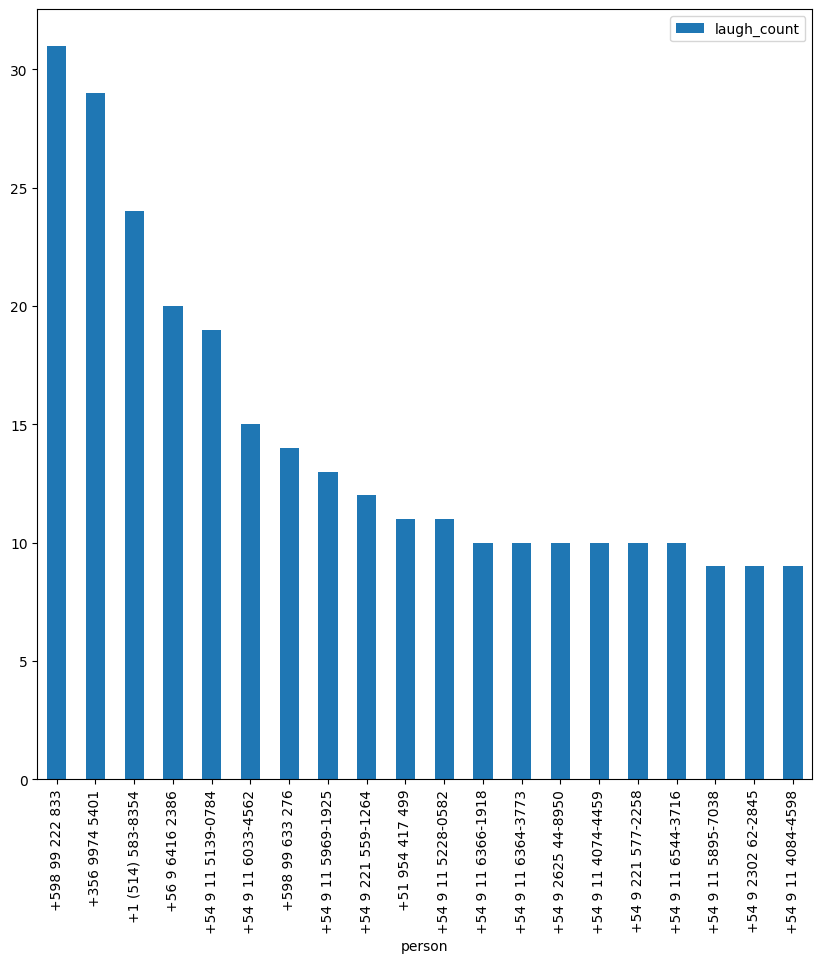

In [14]:
count_laughs = pd.DataFrame(keys, columns=["person"])
count_laughs["laugh_count"] = 0

for person, messages in messages_by_person:
    person = person
    messages = messages
    laugh_count_for_person = messages["Message_Clean"].apply(is_laugh).sum()
    count_laughs.loc[count_laughs['person'] == person, 'laugh_count'] += laugh_count_for_person

count_laughs.sort_values("laugh_count", ascending=False).head(20).plot(kind="bar", x="person", y="laugh_count")


<Axes: xlabel='person'>

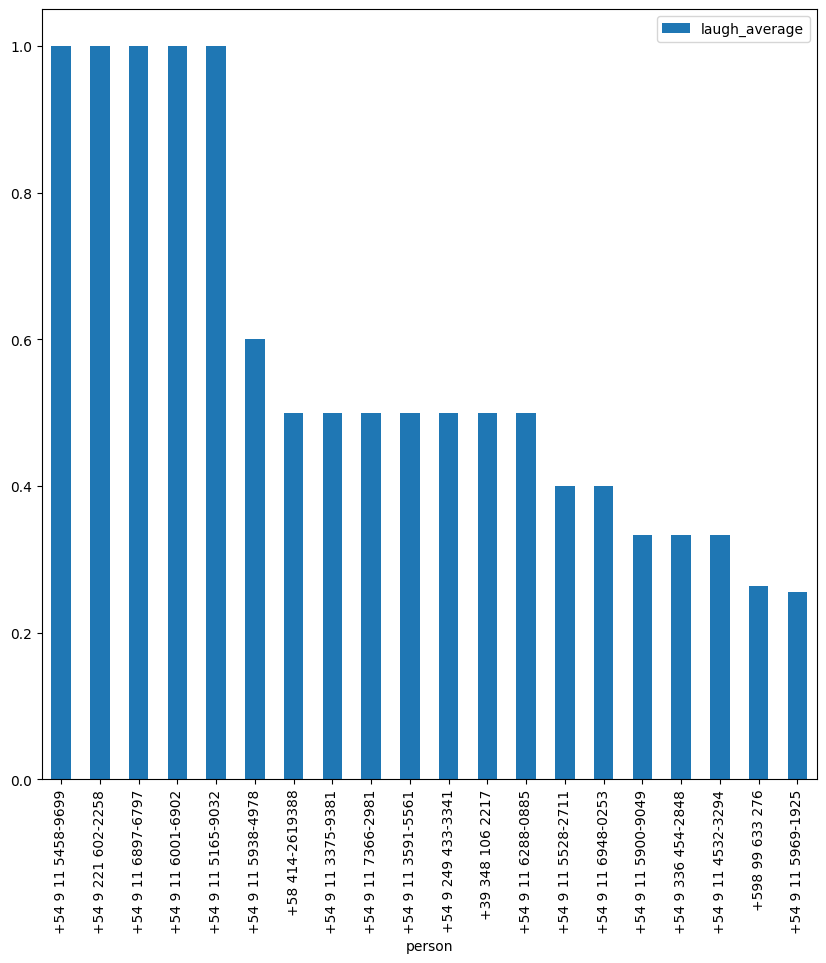

In [23]:
average_laughs = pd.DataFrame(keys, columns=["person"])
for _, item in count_laughs.iterrows():
    person = item["person"]
    average_laughs.loc[average_laughs['person'] == person, 'laugh_average'] = count_laughs.loc[count_laughs["person"] == person, "laugh_count"].iloc[0] / len(messages_by_person.get_group(person))

average_laughs.sort_values("laugh_average", ascending=False).head(20).plot(kind="bar", x="person", y="laugh_average")


## Average toxicity by person

<Axes: xlabel='plain_phone_number'>

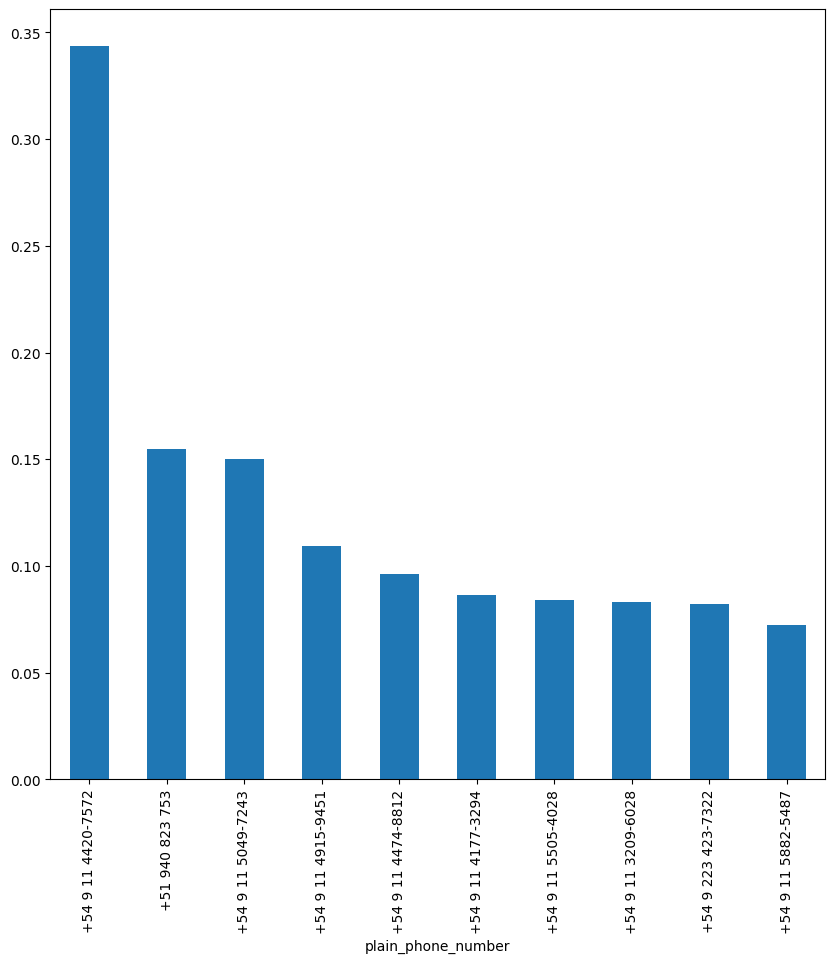

In [45]:
toxic_messages = after_process.groupby("plain_phone_number").mean(numeric_only=True)
toxic_messages["Toxicity"].sort_values(ascending=False).head(10).plot(kind="bar")

### Top 10 most toxic messages

In [98]:
after_process.nlargest(10, "Toxicity")[["Message_Clean", "Toxicity","plain_phone_number","Date"]].reset_index()

,index,Message_Clean,Toxicity,plain_phone_number,Date
0,0,Me desvelo sus estúpidos y desubicados comentarios,0.988293,+54 9 11 4420-7572,2024-04-07 03:36:00
1,0,😅😅 Tenía que ser argentino el muy maldito!,0.980533,+54 9 11 4084-4598,2024-05-07 12:02:00
2,0,Corto mano corto fierro cuando te mueras vas al infierno!🤣🤣,0.979675,+54 9 11 6544-3716,2024-04-19 13:16:00
3,0,Dos una cobarde que eliminaste todos tus dichos: yo no. No jodas más por favor. Tomate una quetiapina y dormí,0.976592,+54 9 11 4420-7572,2024-04-07 03:48:00
4,0,En el sonido y la furia hay un protagonista brillantemente escrito que representa a un idiota por favor si pueden lean el libro,0.964557,+54 9 11 3209-6028,2024-03-21 14:43:00
5,0,No voy a dejar de escribir porque una idiota me lo diga,0.964308,+54 9 11 4420-7572,2024-04-07 03:48:00
6,0,"Hay algo que está más allá de ser peronista, macrista, kirchnerista o cualquier otro ista. Argentina hasta no hace mucho era un ejemplo en el mundo entero sobre derechos humanos. En España desaparecieron y mataron a 130.000 personas, 100.000 mas que en Argentina. Aún siguen estando enterrados/as como N.N. Si hablamos de escritores y algunos/as quieren hablar sobre poesia, los huesos de García Lorca ( como los de miles de personas) siguen sin tener una sepultura digna por parte de sus familias. Los milicos de esa epoca nunca fueron juzgados. Esto tambien es para ese silencio complice y esa vision de que Argentina es "" este pais de mierda"". No importan los motivos por los que muchos/as no estamos ahí pero sepan que nuestro pais no es "" este pais de mierda"". No dejen que lo logren.",0.950384,+356 9974 5401,2024-03-21 13:36:00
7,0,"Me parece que la gula de Dante se relaciona al poder, a la ostentación, del mismo modo que asocia la ira a la soberbia. En el fondo, la Comedia es un escrito político mas que religioso. Ciaco se convierte en bufón y parásito por la gula y eso le permite vivir y comer bien en la meda de los poderosos. Es, en suma, un egoista",0.940821,+54 9 221 559-1264,2024-04-08 17:21:00
8,0,"No soy una cobarde, los elimine porque a diferencia de vos a mi la gente como vos me da pena, es como herir a un perro herido",0.931517,+356 9974 5401,2024-04-07 03:49:00
9,0,LAGO PUELO CUNA DEL LÚPULO Y PEJERREY,0.931170,+54 9 11 5882-5487,2024-03-28 16:09:00


In [60]:
spanish_stopwords = stopwords.words("spanish")
spanish_stopwords.extend(["q", "dsp", "si", "<", ">", "multimedia", "omitido", "omitida", "\u200eaudio", "\u200eimagen", "\u200esticker", "\u200evideo", "\u200egif", "", "Hola", "t", "d", ""])

In [63]:
nltk.download("punkt")
!python -m spacy download es_core_news_sm

[nltk_data] Downloading package punkt to /home/juan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [64]:
nlp = spacy.load("es_core_news_sm")

In [65]:
def lemmatize(message):
    return [token.lemma_ for token in nlp(message)]

def remove_word(word):
    return word in spanish_stopwords or is_laugh(word) or len(word) <= 3

def process_message(message):
    return [ token for token in nltk.word_tokenize(message.translate(str.maketrans('', '', string.punctuation))) if not remove_word(token.lower()) ]

In [66]:
process_message("Hola, como estas vos?")

['Hola']

In [67]:
messages_without_stopwords = []
for index, message in after_process.iterrows():
    new_message = message.copy()
    new_message["Message_Only_Text"] = " ".join(process_message(message["Message_Only_Text"]))
    messages_without_stopwords.append(new_message)

## Most frequently used words per person

In [89]:
messages_per_person_without_stopwords = {key: [] for key in keys}

for person, messages in messages_by_person:
    for message in messages.iterrows():
        new_message = process_message(message[1]["Message_Only_Text"])
        messages_per_person_without_stopwords[person].extend(new_message)

In [82]:
most_used_words = dict.fromkeys(keys, 0)
for person in messages_per_person_without_stopwords:
    most_used_words[person] = Counter(messages_per_person_without_stopwords[person])

In [102]:
Counter(messages_per_person_without_stopwords["+54 9 11 4420-7572"]).most_common(10)

[('puede', 3),
 ('escribir', 2),
 ('favor', 2),
 ('bien', 2),
 ('hace', 2),
 ('mujer', 2),
 ('dasein', 2),
 ('742024', 2),
 ('eliminó', 2),
 ('pueden', 1)]

In [88]:
messages_per_person_without_stopwords

{'+54 9 11 5796-9056': [],
 '+57 312 2577459': [],
 '+52 961 306 6003': [],
 '+54 9 11 5969-1925': [],
 '+52 81 1556 3569': [],
 '+54 9 381 541-1918': [],
 '+54 9 11 6276-5125': [],
 '+54 9 11 5584-8279': [],
 '+54 9 2983 57-4446': [],
 '+54 9 11 6214-1409': [],
 '+54 9 297 433-6371': [],
 '+54 9 11 5156-8806': [],
 '+54 9 2625 44-8950': [],
 '+54 9 11 3569-7401': [],
 '+54 9 3775 41-6419': [],
 '+54 9 11 2499-6642': [],
 '+54 9 11 6410-8594': [],
 '+54 9 11 6018-6040': [],
 '+54 9 280 437-5229': [],
 '+54 9 11 2182-4176': [],
 '+54 9 11 6201-6893': [],
 '+54 9 11 5922-1806': [],
 '+54 9 249 450-0193': [],
 '+54 9 11 3577-0440': [],
 '+54 9 11 5165-4268': [],
 '+54 9 11 5099-7043': [],
 '+54 9 381 574-4523': [],
 '+54 9 11 5989-6672': [],
 '+54 9 341 660-9905': [],
 '+54 9 358 422-1001': [],
 '+54 9 341 610-3253': [],
 '+54 9 299 418-8412': [],
 '+54 9 11 5569-0423': [],
 '+54 9 11 6163-8088': [],
 '+54 9 11 5771-2057': [],
 '+972 58-675-0956': [],
 '+52 221 858 1463': [],
 '+57 312 44